**Group Members**
1. Chukwunonso Francis Obiokala - K2444288
2. Gbemileke Anrew MicaH - K2457391
3. Manan Gandhi- K2500523
4. Malik Munib Ur Rahman - K2506356

TASK - Image Classification with the Oxford-IIIT Pet Dataset

Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import csv
import os
import shutil
import random
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

Preprocessing Functions

In [ ]:
# Download dataset and saving in a directory
def load_pet_dataset():
    """Load and preprocess Oxford-IIIT Pet Dataset

    Data loading implementation adapted from TensorFlow Team (2023)
    with modifications for breed-species classification.
    """
    print("Downloading dataset from url")
    dataset_images_url = "https://thor.robots.ox.ac.uk/pets/images.tar.gz"
    dataset_annotation_url = "https://thor.robots.ox.ac.uk/pets/annotations.tar.gz"

    data_dir = tf.keras.utils.get_file(fname='images.tar.gz', origin=dataset_images_url, extract=True)
    annotation_dir = tf.keras.utils.get_file(fname='annotations.tar.gz', origin=dataset_annotation_url, extract=True)

    data_dir = pathlib.Path(data_dir).with_suffix('')
    annotation_dir = pathlib.Path(annotation_dir).with_suffix('')

    print(f"Image dataset can be found in {data_dir}")
    print(f"Number of files in the Image dataset directory is: {len(list(data_dir.glob('*/*.jpg')))}")
    print(f"Annotation dataset can be found in {annotation_dir}")
    print(f"Number of files in the Annotation dataset directory is: {len(list(annotation_dir.glob('*/*.txt')))}")

    return data_dir, annotation_dir

In [ ]:
# Creating a list.csv to capture content of the dataset
def create_list(annotation_dir):
    dataset_list = os.path.join(annotation_dir, "annotations", "list.csv")
    print("list.csv file created")
    list_txt = os.path.join(annotation_dir, "annotations", "list.txt")

    with open(dataset_list, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Filename", "Class ID", "Species", "Breed ID"])

        with open(list_txt, "r") as annotation_file:
            lines = annotation_file.readlines()[6:]

            for line in lines:
                parts = line.strip().split()
                filename, class_id, species_id, breed_id = parts[0], int(parts[1]), int(parts[2]), int(parts[3])

                writer.writerow([filename, class_id, species_id, breed_id])

    print(f"list.csv directory is: {dataset_list}")
    print("list.csv contains compiled information about the dataset")
    return dataset_list

In [ ]:
def visualize_species_distribution(dataset_list):
    print("Visual Representation of Species Distribution")
    distribution = dataset_list["Species"].value_counts()

    plt.figure(figsize=(6, 6))
    distribution.plot(kind="bar", color=["brown", "yellow"], edgecolor="black")

    plt.title("Distribution of Dogs vs Cats", fontsize=14)
    plt.xlabel("Species", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


In [ ]:
def visualize_dog_breed_distribution(dataset_list):
    print("Visual Representation of Dogs Breed Distribution")
    dogs_df = dataset_list[dataset_list["Species"] == 2]

    dog_breed_counts = dogs_df["Breed ID"].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    dog_breed_counts.plot(kind="bar", color="blue", edgecolor="black")
    plt.title("Distribution of Dog Breeds", fontsize=14)
    plt.xlabel("Breed ID (1-25)", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
def visualize_cat_breed_distribution(dataset_list):
    print("Visual Representation of Cat Breed Distribution")
    cats_df = dataset_list[dataset_list["Species"] == 1]

    cat_breed_counts = cats_df["Breed ID"].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    cat_breed_counts.plot(kind="bar", color="orange", edgecolor="black")
    plt.title("Distribution of Cat Breeds", fontsize=14)
    plt.xlabel("Breed ID (1-12)", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
def visualize_Class_distribution(dataset_list):
    print("Visual Representation of Class Distribution")
    distribution = dataset_list["Class ID"].value_counts().sort_index()

    plt.figure(figsize=(12, 8))
    distribution.plot(kind="bar", color="darkblue", edgecolor="black")
    plt.title("Class Distribution of Oxford-IIIT Pet Dataset", fontsize=14)
    plt.xlabel("Class ID (1-37)", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
# Creating a structured directory to choose train, validation and test samples MODEL 1 (Cats vs Dogs)
def create_Cat_vs_Dog_Dir(data_dir, annotation_dir):
    print("Moving Images to Cat_vs_Dogs Directory")
    source_dir = os.path.join(data_dir, "images")
    dest_dir = data_dir

    os.makedirs(os.path.join(dest_dir, "Cat_vs_Dogs", "train", "dogs"), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, "Cat_vs_Dogs", "train", "cats"), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, "Cat_vs_Dogs", "val", "dogs"), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, "Cat_vs_Dogs", "val", "cats"), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, "Cat_vs_Dogs", "test", "dogs"), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, "Cat_vs_Dogs", "test", "cats"), exist_ok=True)

    df = pd.read_csv(os.path.join(annotation_dir, "annotations", "list.csv"))

    cat_images = df[df["Species"] == 1]["Filename"].tolist()
    dog_images = df[df["Species"] == 2]["Filename"].tolist()

    random.shuffle(cat_images)
    random.shuffle(dog_images)

    num_cats = len(cat_images)
    dog_images = dog_images[:num_cats]

    print(f"Number of cat images: {num_cats}")
    print(f"Number of dog images after trimming: {len(dog_images)}")

    def split_and_move(images, category):
        train_split = int(0.8 * len(images))
        val_split = int(0.9 * len(images))

        sets = {"train": images[:train_split], "val": images[train_split:val_split], "test": images[val_split:]}

        for set_name, file_list in sets.items():
            for filename in file_list:
                src_path = os.path.join(source_dir, filename + ".jpg")
                dest_path = os.path.join(dest_dir, "Cat_vs_Dogs", set_name, category, filename + ".jpg")

                if os.path.exists(src_path):
                    shutil.move(src_path, dest_path)
                else:
                    print(f"File not found: {src_path}")

    split_and_move(cat_images, "cats")
    split_and_move(dog_images, "dogs")

    train_dir = os.path.join(dest_dir, "Cat_vs_Dogs", "train")
    val_dir = os.path.join(dest_dir, "Cat_vs_Dogs", "val")
    test_dir = os.path.join(dest_dir, "Cat_vs_Dogs", "test")

    return  train_dir, val_dir, test_dir

In [ ]:
# Creating a structured directory to choose train, validation and test samples MODEL 2 (Cat Classificaion)
def create_cat_breed_dir(data_dir, annotation_dir):
    source_dir = os.path.join(data_dir, "images")
    dest_dir = data_dir

    df = pd.read_csv(os.path.join(annotation_dir, "annotations", "list.csv"))

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(dest_dir, "Cat_Breed", split), exist_ok=True)

    cat_breeds = df[df["Species"] == 1]["Breed ID"].unique()

    def split_and_move(images, breed):
        train_split = int(0.8 * len(images))
        val_split = int(0.9 * len(images))

        sets = {"train": images[:train_split], "val": images[train_split:val_split], "test": images[val_split:]}

        for set_name, file_list in sets.items():
            breed_dir = os.path.join(dest_dir, "Cat_Breed", set_name, str(breed))
            os.makedirs(breed_dir, exist_ok=True)  # Ensure breed folder exists

            for filename in file_list:
                src_path = os.path.join(source_dir, filename + ".jpg")
                dest_path = os.path.join(breed_dir, filename + ".jpg")

                if os.path.exists(src_path):
                    shutil.move(src_path, dest_path)
                else:
                    print(f"File not found: {src_path}")

    for breed in cat_breeds:
        cat_images = df[(df["Species"] == 1) & (df["Breed ID"] == breed)]["Filename"].tolist()
        random.shuffle(cat_images)
        split_and_move(cat_images, breed)

    train_dir = os.path.join(dest_dir, "Cat_Breed", "train")
    val_dir = os.path.join(dest_dir, "Cat_Breed", "val")
    test_dir = os.path.join(dest_dir, "Cat_Breed", "test")

    return train_dir, val_dir, test_dir



In [ ]:
# Creating a structured directory to choose train, validation and test samples MODEL 3 (Dog Classificiation)
def create_dog_breed_dir(data_dir, annotation_dir):
    source_dir = os.path.join(data_dir, "images")
    dest_dir = data_dir

    df = pd.read_csv(os.path.join(annotation_dir, "annotations", "list.csv"))

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(dest_dir, "Dog_Breed", split), exist_ok=True)

    cat_breeds = df[df["Species"] == 2]["Breed ID"].unique()

    def split_and_move(images, breed):
        train_split = int(0.8 * len(images))
        val_split = int(0.9 * len(images))

        sets = {"train": images[:train_split], "val": images[train_split:val_split], "test": images[val_split:]}

        for set_name, file_list in sets.items():
            breed_dir = os.path.join(dest_dir, "Dog_Breed", set_name, str(breed))
            os.makedirs(breed_dir, exist_ok=True)

            for filename in file_list:
                src_path = os.path.join(source_dir, filename + ".jpg")
                dest_path = os.path.join(breed_dir, filename + ".jpg")

                if os.path.exists(src_path):
                    shutil.move(src_path, dest_path)
                else:
                    print(f"File not found: {src_path}")

    for breed in cat_breeds:
        dog_images = df[(df["Species"] == 2) & (df["Breed ID"] == breed)]["Filename"].tolist()
        random.shuffle(dog_images)
        split_and_move(dog_images, breed)

    train_dir = os.path.join(dest_dir, "Dog_Breed", "train")
    val_dir = os.path.join(dest_dir, "Dog_Breed", "val")
    test_dir = os.path.join(dest_dir, "Dog_Breed", "test")

    return train_dir, val_dir, test_dir

In [ ]:
# Creating a structured directory to choose train, validation and test samples  MODEL 4 (All Breed Classification)
def create_class_id_dir(data_dir, annotation_dir):
    source_dir = os.path.join(data_dir, "images")
    dest_dir = os.path.join(data_dir, "Class_ID")

    df = pd.read_csv(os.path.join(annotation_dir, "annotations", "list.csv"))

    class_ids = df["Class ID"].unique()

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(dest_dir, split), exist_ok=True)

    for split in ["train", "val", "test"]:
        for class_id in class_ids:
            os.makedirs(os.path.join(dest_dir, split, str(class_id)), exist_ok=True)

    def split_and_move(images, class_id):
        random.shuffle(images)
        train_split = int(0.8 * len(images))
        val_split = int(0.9 * len(images))

        sets = {"train": images[:train_split], "val": images[train_split:val_split], "test": images[val_split:]}

        for set_name, file_list in sets.items():
            for filename in file_list:
                src_path = os.path.join(source_dir, filename + ".jpg")
                dest_path = os.path.join(dest_dir, set_name, str(class_id), filename + ".jpg")

                #dest_path = os.path.join(dest_dir, set_name, str(filename + ".jpg"))

                if os.path.exists(src_path):
                    shutil.move(src_path, dest_path)
                else:
                    print(f"File not found: {src_path}")

    for class_id in class_ids:
        images = df[df["Class ID"] == class_id]["Filename"].tolist()
        split_and_move(images, class_id)


    train_dir = os.path.join(data_dir, "Class_ID", "train")
    val_dir = os.path.join(data_dir, "Class_ID", "val")
    test_dir = os.path.join(data_dir, "Class_ID", "test")

    return train_dir, val_dir, test_dir

In [ ]:
# Loading Dataset from directory using Keras.util
def load_dataset_from_directory(train_dir, val_dir, test_dir, batch_size, img_height, img_width, data_generator=False):
    if not data_generator:
        print("Loading image dataset from directory using keras.utils")
        train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, labels="inferred", validation_split=None, subset=None, seed=42, image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=True)

        val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, labels="inferred", validation_split=None, subset=None, seed=42, image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=True)

        test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, labels="inferred", validation_split=None, subset=None, seed=None, shuffle=False, image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=True)

        class_names = train_ds.class_names
        num_classes = len(class_names)
        print(f"Number of Classes: {num_classes}")
        return train_ds, val_ds, test_ds, num_classes, class_names
    else:
        print("Loading image dataset from directory using ImageGenerator")

        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=2, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

        train_ds = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', seed=132, shuffle=True)
        val_ds = datagen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', seed=132, shuffle=True)
        test_ds = datagen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', seed=132, shuffle=False)

        num_classes = train_ds.num_classes
        print(f"Number of Classes: {num_classes}")
        return train_ds, val_ds, test_ds, num_classes

In [1]:
def visualize_model_training(model_history, epochs, title="Model"):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 12))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, linestyle='--', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, linestyle='--', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} Training and Validation Loss')
    plt.show()



In [ ]:
def evalutate_model(model, test_ds):
    print("Model Evaluation")
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    return test_loss, test_acc

In [ ]:
# using sklearn
def model_classification_report(model, test_ds, class_names=None, title="Confusion_Matrix", data_generator=False):
    if  not data_generator:
        # Test dataset from directory (tf.data.Dataset)
        y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
        y_pred = model.predict(test_ds).argmax(axis=1)

    else:
        # Test dataset from ImageDataGenerator
        y_true = test_ds.classes
        y_pred_probs = model.predict(test_ds)

        y_pred = np.argmax(y_pred_probs, axis=1)
        #y_pred = model.predict(test_ds).argmax(axis=1)
        if class_names == None:
            class_names = list(test_ds.class_indices.keys())

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{title}")
    plt.show()


Model 1 - Species Classification - Built from Scratch

791918971/791918971 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step
19173078/19173078 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Image dataset can be found in C:\Users\fobio\.keras\datasets\images_extracted
Number of files in the Image dataset directory is: 7390
Annotation dataset can be found in C:\Users\fobio\.keras\datasets\annotations_extracted
Number of files in the Annotation dataset directory is: 3
list.csv file created
list.csv directory is: C:\Users\fobio\.keras\datasets\annotations_extracted\annotations\list.csv
list.csv contains compiled information about the dataset
Visual Representation of Species Distribution


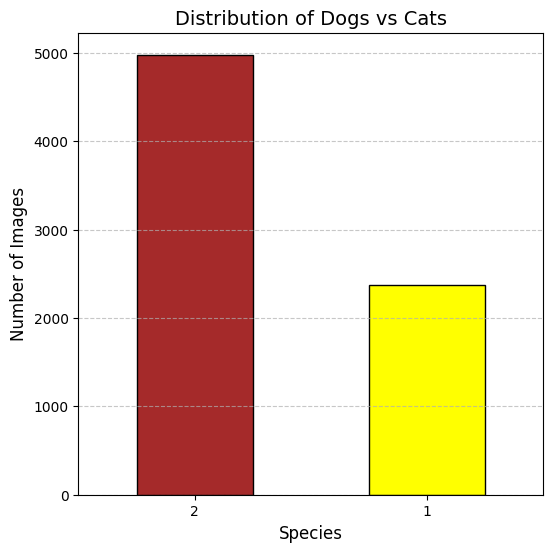

Moving Images to Cat_vs_Dogs Directory
Number of cat images: 2371
Number of dog images after trimming: 2371


In [ ]:
data_dir, annotation_dir = load_pet_dataset()
dataset_list_dir = create_list(annotation_dir)
dataset_df = pd.read_csv(dataset_list_dir)
visualize_species_distribution(dataset_df)

# Loading dataset from diretory and train
train_dir, val_dir, test_dir = create_Cat_vs_Dog_Dir(data_dir, annotation_dir)

In [ ]:
# Model configuration constants (Howard et al., 2019)
batch_size = 50
img_height = 224
img_width = 224 # MobileNetV2 default input size

train_ds, val_ds, test_ds, num_classes, class_names = load_dataset_from_directory(train_dir, val_dir, test_dir, batch_size, img_height, img_width)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.15), layers.RandomContrast(0.05),])

model = Sequential([layers.Input(shape=(img_height, img_width, 3)), layers.Rescaling(1./255), data_augmentation, layers.Conv2D(16, 3, padding='same', activation='relu'), layers.MaxPooling2D(), layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(), layers.Conv2D(64, 3, padding='same', activation='relu'), layers.MaxPooling2D(), layers.Flatten(), layers.Dropout(0.1), layers.Dense(128, activation='relu'), layers.Dense(num_classes)])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1),
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)])

Loading image dataset from directory using keras.utils
Found 3792 files belonging to 2 classes.
Found 474 files belonging to 2 classes.
Found 476 files belonging to 2 classes.
Number of Classes: 2


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,498 (24.59 MB)

 Trainable params: 6,446,498 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.5093 - loss: 0.8955 - val_accuracy: 0.5696 - val_loss: 0.6738 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.6017 - loss: 0.6672 - val_accuracy: 0.6688 - val_loss: 0.6250 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.6444 - loss: 0.6343 - val_accuracy: 0.6793 - val_loss: 0.6094 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.6702 - loss: 0.6097 - val_accuracy: 0.6772 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.6748 - loss: 0.5949 - val_accuracy: 0.6287 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.6959 - loss: 0.5780 - val_accuracy: 0.6962 - val_loss: 0.5805 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.7195 - loss: 0.

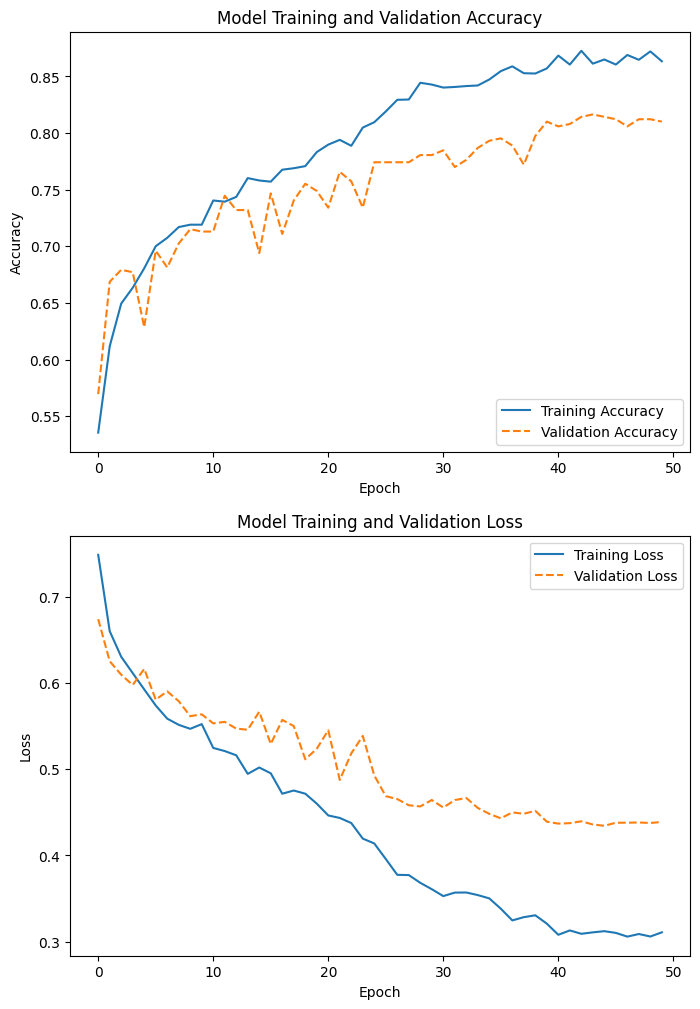

Model Evaluation
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8092 - loss: 0.5724
Test Accuracy: 0.7941
Test Loss: 0.5496


(0.5495551228523254, 0.7941176295280457)

In [ ]:
visualize_model_training(history, epochs)
evalutate_model(model, test_ds)
# IF THE VISUALIZE_MODEL_TRAINING FUNCTION RETURNS AN ERROR, THIS IS BECAUSE OF THE CALLBACK "EARLYSTOPPING" EPOCH RAN NOT COMPLETE.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
              precision    recall  f1-score   support

        cats       0.77      0.83      0.80       238
        dogs       0.82      0.76      0.79       238

    accuracy                           0.79       476
   macro avg       0.80      0.79      0.79       476
weighted avg       0.80      0.79      0.79       476



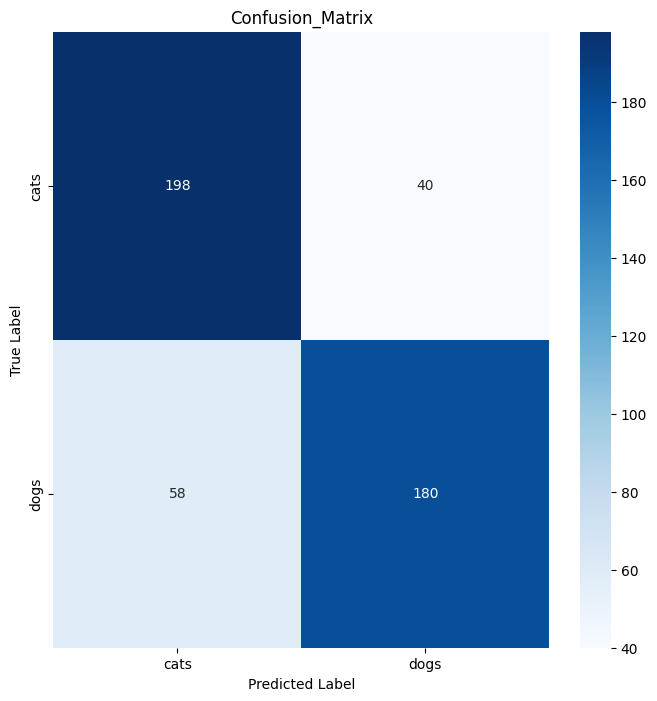

In [ ]:
model_classification_report(model, test_ds, class_names=class_names)

Model 2 - Cat Breed Classification - Used Pretrained Model MobileNetv2

Image dataset can be found in C:\Users\fobio\.keras\datasets\images_extracted
Number of files in the Image dataset directory is: 7390
Annotation dataset can be found in C:\Users\fobio\.keras\datasets\annotations_extracted
Number of files in the Annotation dataset directory is: 3
list.csv file created
list.csv directory is: C:\Users\fobio\.keras\datasets\annotations_extracted\annotations\list.csv
list.csv contains compiled information about the dataset
Visual Representation of Cat Breed Distribution


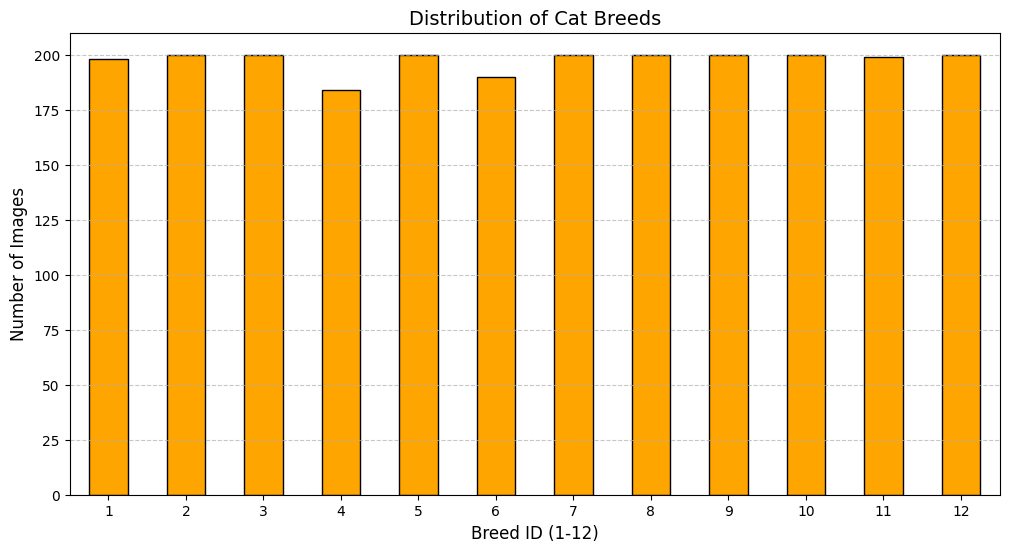

In [ ]:
data_dir, annotation_dir = load_pet_dataset()
dataset_list = create_list(annotation_dir)
dataset_df = pd.read_csv(dataset_list)
visualize_cat_breed_distribution(dataset_df)
train_dir, val_dir, test_dir = create_cat_breed_dir(data_dir, annotation_dir)

In [ ]:
# Model configuration constants (Howard et al., 2019)
batch_size = 64
img_height = 224
img_width = 224

train_ds, val_ds, test_ds, num_classes = load_dataset_from_directory(train_dir, val_dir, test_dir, batch_size, img_height, img_width, data_generator=True)


callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, verbose=1), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True),
           tf.keras.callbacks.ModelCheckpoint("cat_best_model.h5", save_best_only=True)]
"""Improved model architecture

    Based on MobileNetV2 architecture (Howard et al., 2019)
    with custom classification head and fine-tuning approach.
"""
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

cat_model = Sequential([base_model, GlobalAveragePooling2D(),  layers.Dropout(0.2), layers.Dense(512, activation='relu'), layers.Dropout(0.4), layers.Dense(num_classes, activation='softmax')])
cat_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])


cat_model.summary()

epochs = 50
history = cat_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Loading image dataset from directory using ImageGenerator
Found 2352 images belonging to 12 classes.
Found 638 images belonging to 12 classes.
Found 650 images belonging to 12 classes.
Number of Classes: 12


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,920,012 (11.14 MB)

 Trainable params: 662,028 (2.53 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 905ms/step - accuracy: 0.4221 - loss: 1.8131 - val_accuracy: 0.8511 - val_loss: 0.4661
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 943ms/step - accuracy: 0.7977 - loss: 0.5931 - val_accuracy: 0.8809 - val_loss: 0.3500
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 902ms/step - accuracy: 0.8451 - loss: 0.4415 - val_accuracy: 0.9013 - val_loss: 0.2867
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 904ms/step - accuracy: 0.8596 - loss: 0.4019 - val_accuracy: 0.9060 - val_loss: 0.2716
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 907ms/step - accuracy: 0.8822 - loss: 0.3363 - val_accuracy: 0.9060 - val_loss: 0.2435
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 892ms/step - accuracy: 0.8906 - loss: 0.3000 - val_accuracy: 0.9342 - val_loss: 0.2134
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 894ms/step - accuracy: 0.9237 - loss: 0.2450 - val_accuracy: 0.9326 - val_loss: 0.2074
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 889ms/step - accuracy: 0.9093 - loss: 0.2589 - val_accu

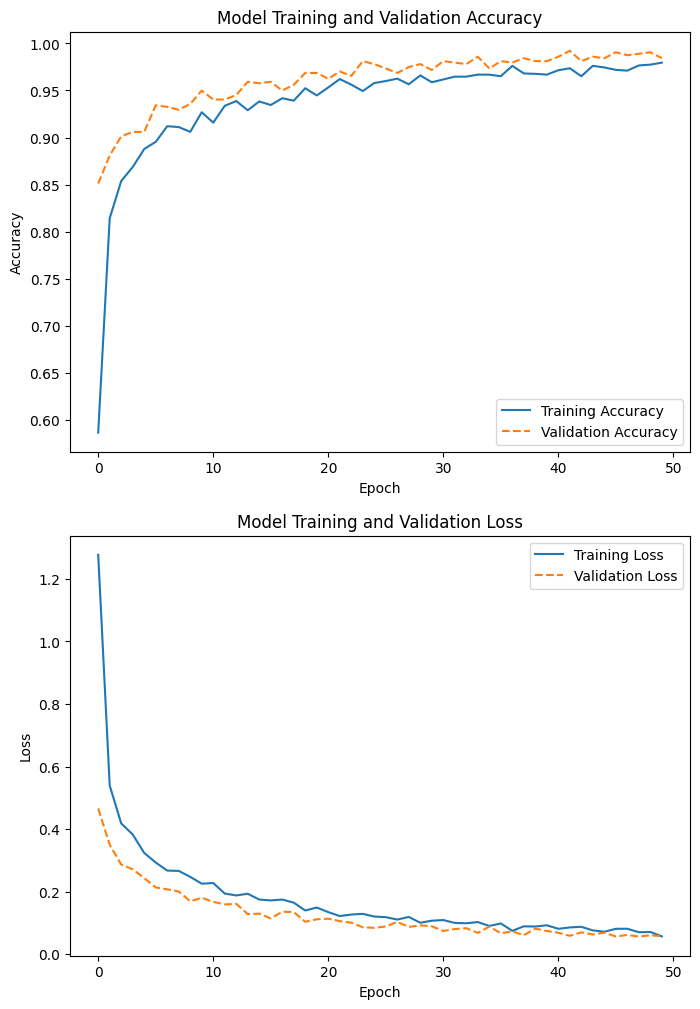

Model Evaluation


c:\Users\fobio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 589ms/step - accuracy: 0.9928 - loss: 0.0431
Test Accuracy: 0.9938
Test Loss: 0.0535
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        53
          10       0.98      1.00      0.99        56
          11       1.00      1.00      1.00        52
          12       1.00      1.00      1.00        56
           2       1.00      0.98      0.99        54
           3       1.00      1.00      1.00        55
           4       0.98      1.00      0.99        50
           5       0.98      0.96      0.97        56
           6       0.98      1.00      0.99        52
           7       1.00      1.00      1.00        56
           8       1.00      1.00      1.00        55
           9       1.00      1.00      1.00        55

    accuracy                           0.99       650
   macro avg       0.99      0.99      0.99       650
weighted avg       0.99      0.9

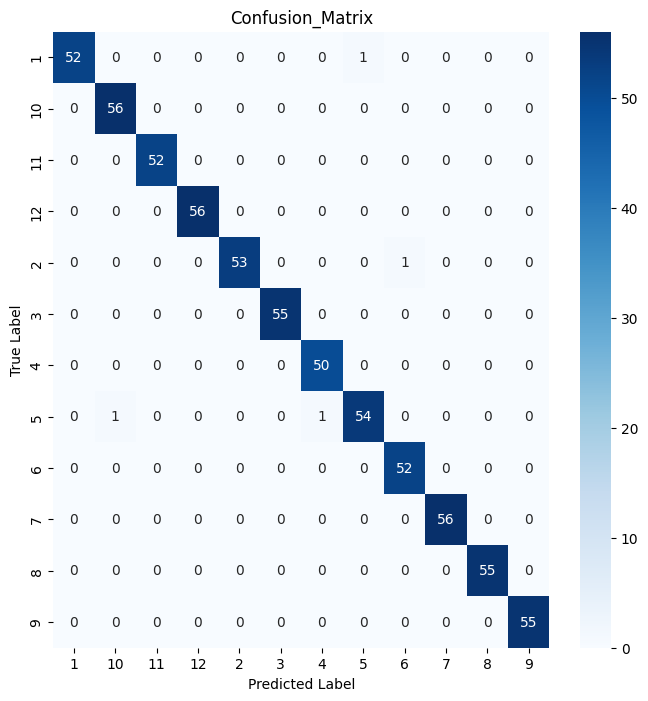

In [ ]:
visualize_model_training(history, epochs)
evalutate_model(cat_model, test_ds)
model_classification_report(cat_model, test_ds, data_generator=True)

Model 3 - Dog Breed Classification - Used Pretrained Model MobileNetv2

Image dataset can be found in C:\Users\fobio\.keras\datasets\images_extracted
Number of files in the Image dataset directory is: 7390
Annotation dataset can be found in C:\Users\fobio\.keras\datasets\annotations_extracted
Number of files in the Annotation dataset directory is: 3
list.csv file created
list.csv directory is: C:\Users\fobio\.keras\datasets\annotations_extracted\annotations\list.csv
list.csv contains compiled information about the dataset
Visual Representation of Dogs Breed Distribution


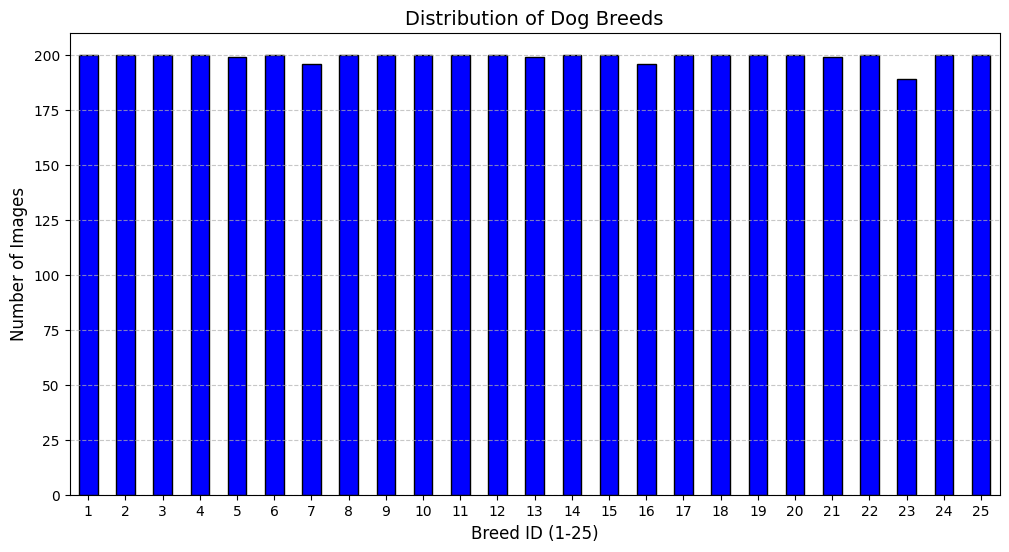

In [ ]:
data_dir, annotation_dir = load_pet_dataset()
dataset_list = create_list(annotation_dir)
dataset_df = pd.read_csv(dataset_list)
visualize_dog_breed_distribution(dataset_df)
train_dir, val_dir, test_dir = create_dog_breed_dir(data_dir, annotation_dir)

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

train_ds, val_ds, test_ds, num_classes = load_dataset_from_directory(train_dir, val_dir, test_dir, batch_size, img_height, img_width, data_generator=True)

"""Improved model architecture

    Based on MobileNetV2 architecture (Howard et al., 2019)
    with custom classification head and fine-tuning approach.
"""
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

dog_model = Sequential([base_model, layers.GlobalAveragePooling2D(), layers.Dropout(0.2), layers.Dense(1024, activation='relu'), layers.Dropout(0.4), layers.Dense(num_classes, activation='softmax')])


dog_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

dog_model.summary()

epochs = 50
history = dog_model.fit(train_ds, validation_data=val_ds, epochs=epochs)



Loading image dataset from directory using ImageGenerator
Found 4782 images belonging to 25 classes.
Found 955 images belonging to 25 classes.
Found 932 images belonging to 25 classes.
Number of Classes: 25


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 25)             │        25,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,595,353 (13.72 MB)

 Trainable params: 1,337,369 (5.10 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

c:\Users\fobio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.3364 - loss: 2.5063 - val_accuracy: 0.9058 - val_loss: 0.5501
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8543 - loss: 0.6107 - val_accuracy: 0.9246 - val_loss: 0.3078
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8919 - loss: 0.3872 - val_accuracy: 0.9298 - val_loss: 0.2557
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9075 - loss: 0.3209 - val_accuracy: 0.9455 - val_loss: 0.2173
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9048 - loss: 0.2956 - val_accuracy: 0.9382 - val_loss: 0.2031
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9165 - loss: 0.2667 - val_accuracy: 0.9550 - val_loss: 0.1833
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9200 - loss: 0.2547 - val_accuracy: 0.9518 - val_loss: 0.1776
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9311 - loss: 0.2230 - val_accuracy: 0.9550 - val_loss

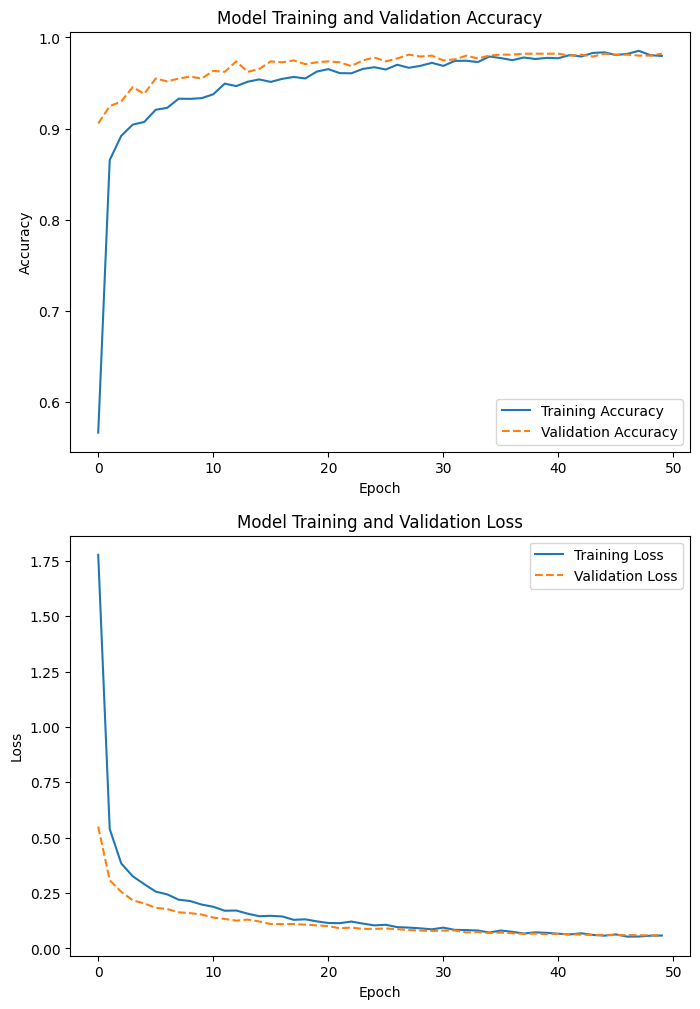

Model Evaluation
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 745ms/step - accuracy: 0.9900 - loss: 0.0319
Test Accuracy: 0.9893
Test Loss: 0.0520
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step
              precision    recall  f1-score   support

           1       0.94      0.97      0.96        35
          10       1.00      1.00      1.00        37
          11       0.97      0.97      0.97        38
          12       1.00      1.00      1.00        36
          13       1.00      1.00      1.00        37
          14       1.00      1.00      1.00        36
          15       1.00      1.00      1.00        38
          16       0.97      1.00      0.99        38
          17       1.00      1.00      1.00        38
          18       1.00      1.00      1.00        37
          19       1.00      0.97      0.99        39
           2       0.95      0.95      0.95        37
          20       1.00      1.00      1.00        37
          21       0.97      1.00      0.99        37
          22   

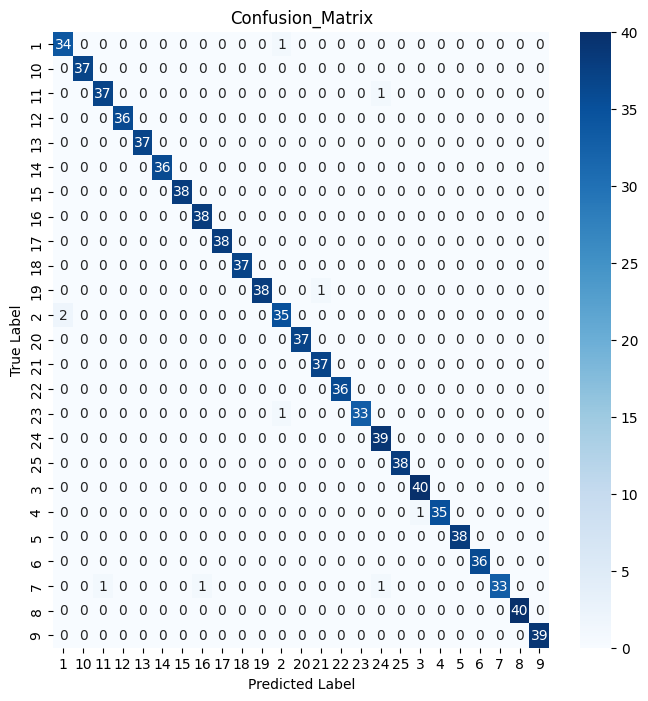

In [ ]:
visualize_model_training(history, epochs)
evalutate_model(dog_model, test_ds)
model_classification_report(dog_model, test_ds, data_generator=True)

Model 4 - Class Classification - Using Pretrained Model MobileNetv2

Image dataset can be found in C:\Users\fobio\.keras\datasets\images_extracted
Number of files in the Image dataset directory is: 7390
Annotation dataset can be found in C:\Users\fobio\.keras\datasets\annotations_extracted
Number of files in the Annotation dataset directory is: 3
list.csv file created
list.csv directory is: C:\Users\fobio\.keras\datasets\annotations_extracted\annotations\list.csv
list.csv contains compiled information about the dataset
Visual Representation of Class Distribution


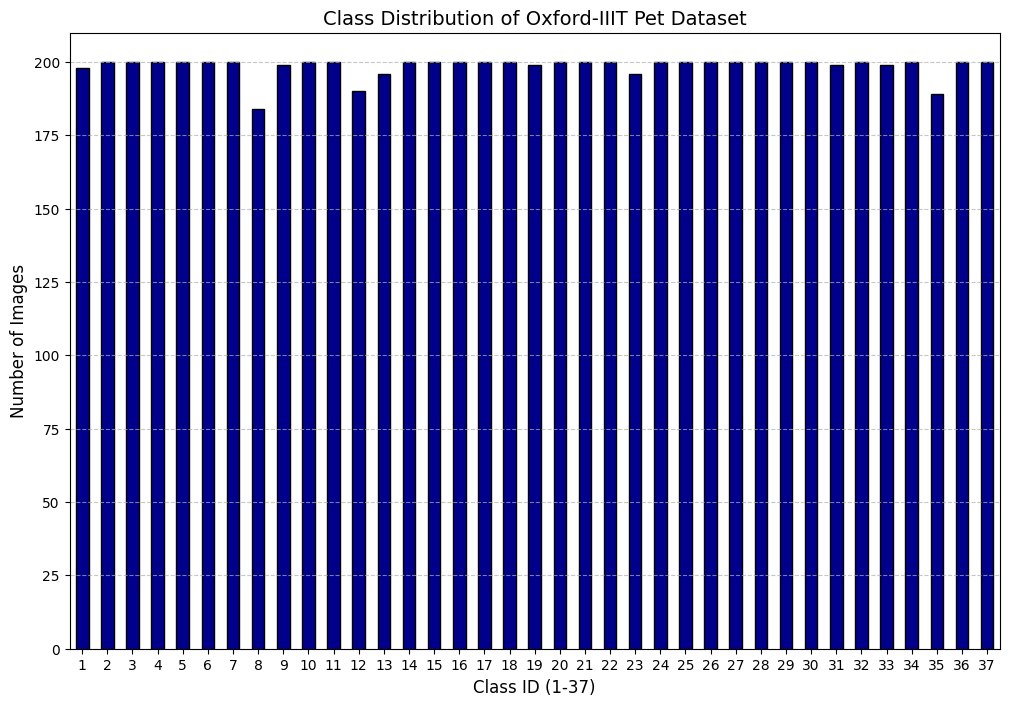

In [ ]:
data_dir, annotation_dir = load_pet_dataset()
dataset_list = create_list(annotation_dir)
dataset_df = pd.read_csv(dataset_list)
visualize_Class_distribution(dataset_df)
train_dir, val_dir, test_dir = create_class_id_dir(data_dir, annotation_dir)

In [ ]:
batch_size = 64
epochs = 50
img_height = 224
img_width = 224

train_ds, val_ds, test_ds, num_classes = load_dataset_from_directory(train_dir, val_dir, test_dir, batch_size, img_height, img_width, data_generator=True)


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False
"""Improved model architecture

    Based on MobileNetV2 architecture (Howard et al., 2019)
    with custom classification head and fine-tuning approach.
"""
breed_model = Sequential([base_model, GlobalAveragePooling2D(), layers.Dropout(0.2), layers.Dense(1024, activation='relu'), layers.Dropout(0.4), Dense(num_classes, activation='softmax')])

breed_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


breed_model.summary()

history = breed_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Loading image dataset from directory using ImageGenerator
Found 7041 images belonging to 37 classes.
Found 1407 images belonging to 37 classes.
Found 1395 images belonging to 37 classes.
Number of Classes: 37


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 37)             │        37,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,607,653 (13.76 MB)

 Trainable params: 1,349,669 (5.15 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

c:\Users\fobio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.2893 - loss: 2.8305 - val_accuracy: 0.8792 - val_loss: 0.6720
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 101s 911ms/step - accuracy: 0.7854 - loss: 0.7995 - val_accuracy: 0.9090 - val_loss: 0.3782
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 104s 939ms/step - accuracy: 0.8384 - loss: 0.5359 - val_accuracy: 0.9133 - val_loss: 0.3114
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 102s 913ms/step - accuracy: 0.8653 - loss: 0.4435 - val_accuracy: 0.9232 - val_loss: 0.2758
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 108s 967ms/step - accuracy: 0.8773 - loss: 0.3759 - val_accuracy: 0.9346 - val_loss: 0.2346
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 104s 940ms/step - accuracy: 0.8904 - loss: 0.3461 - val_accuracy: 0.9367 - val_loss: 0.2169
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 103s 927ms/step - accuracy: 0.8969 - loss: 0.3373 - val_accuracy: 0.9346 - val_loss: 0.2163
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 104s 937ms/step - accuracy: 0.9037 - lo

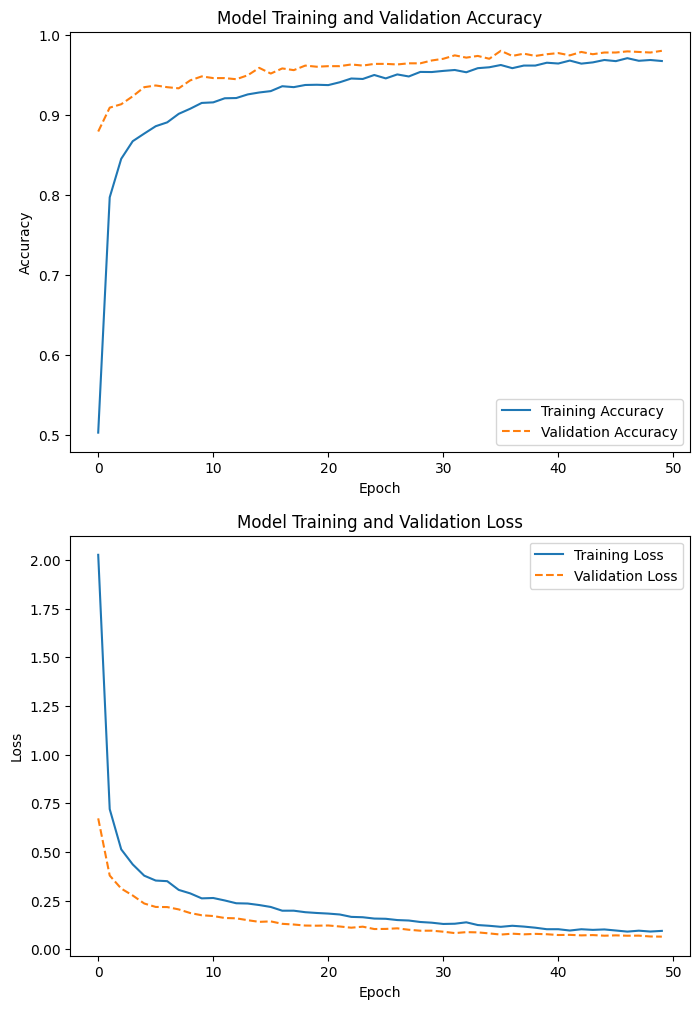

Model Evaluation
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 805ms/step - accuracy: 0.9745 - loss: 0.0777
Test Accuracy: 0.9728
Test Loss: 0.0781
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        35
          10       0.95      0.95      0.95        38
          11       1.00      1.00      1.00        37
          12       1.00      0.97      0.99        36
          13       1.00      0.97      0.99        39
          14       0.97      1.00      0.99        39
          15       1.00      1.00      1.00        38
          16       1.00      0.97      0.99        36
          17       0.97      0.97      0.97        37
          18       1.00      1.00      1.00        37
          19       1.00      1.00      1.00        39
           2       0.90      1.00      0.95        38
          20       1.00      1.00      1.00        36
          21       0.97      1.00      0.99        38
          22  

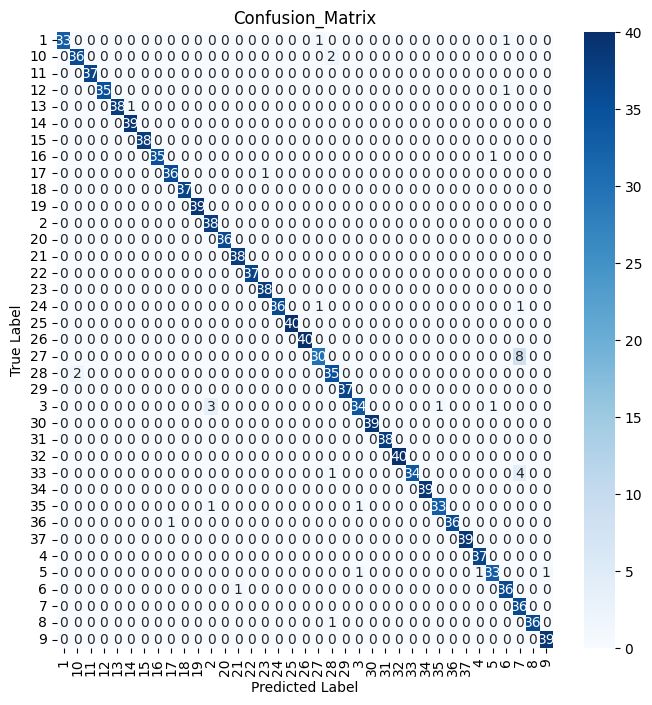

In [ ]:
visualize_model_training(history, epochs)
evalutate_model(breed_model, test_ds)
model_classification_report(breed_model, test_ds, data_generator=True)

# **References**
CNVRG.io (2021) 'How to build CNN in TensorFlow: examples, code and notebooks'. Available at: https://cnvrg.io/cnn-tensorflow/.

Data Science Dojo (2022). Introducing Convolutional Neural Networks | Convolutional Neural Networks with TensorFlow. [online] YouTube. Available at: https://www.youtube.com/watch?v=jZJpBqSeuuA.

DataCamp. (n.d.). Convolutional Neural Networks (CNN) with TensorFlow Tutorial. Available at: https://www.datacamp.com/tutorial/cnn-tensorflow-python

deeplizard (2020). Data Augmentation with TensorFlow’s Keras API. [online] YouTube. Available at: https://www.youtube.com/watch?v=WSvpLUietIM.

KGP Talkie (2019). TensorFlow 2.0 Tutorial for Beginners 3 - Plotting Learning Curve and Confusion Matrix in TensorFlow. [online] YouTube. Available at: https://www.youtube.com/watch?v=SToqP9V9y7Q.

Parkhi, O.M., Vedaldi, A., Zisserman, A. and Jawahar, C.V., 2012. Cats and Dogs. Available at: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet

Patrick Loeber. (2020). TensorFlow Tutorial 05 - Convolutional Neural Network (CNN). [online] Available at: https://www.youtube.com/watch?v=eMMZpas-zX0.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V. and Vanderplas, J., 2011. Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, pp.2825-2830. Available at: https://jmlr.org/papers/v12/pedregosa11a.html

PyImageSearch. (2021). Data augmentation with tf.data and TensorFlow. Available at: https://pyimagesearch.com/2021/06/28/data-augmentation-with-tf-data-and-tensorflow/

Roboflow (n.d.) 'How to create a TensorFlow confusion matrix'. Available at: https://roboflow.com/how-to-create-a-confusion-matrix/tensorflow.

Sandler, M., Howard, A., Zhu, M., Zhmoginov, A. and Chen, L.C., 2018. MobileNetV2: Inverted Residuals and Linear Bottlenecks. arXiv preprint arXiv:1801.04381. Available at: https://arxiv.org/abs/1801.04381

Scaler Topics (2024) 'Data Augmentation with TensorFlow'. Available at: https://www.scaler.com/topics/tensorflow/data-augmentation-tensorflow/.

Stack Overflow. (2017). How to create confusion matrix for classification in tensorflow. Available at: https://stackoverflow.com/questions/43051687/how-to-create-confusion-matrix-for-classification-in-tensorflow

TensorFlow. (n.d.). Convolutional Neural Network (CNN). Available at: https://www.tensorflow.org/tutorials/images/cnn.

TensorFlow. (n.d.). Data augmentation. Available at: https://www.tensorflow.org/tutorials/images/data_augmentation.

TensorFlow. (n.d.). tf.math.confusion_matrix. Available at: https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix.

TensorFlow, n.d. Keras: The High-Level API for TensorFlow. Available at: https://www.tensorflow.org/guide/keras

Howard, A.G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., Andreetto, M. and Adam, H. (2019) 'MobileNets: Efficient convolutional neural networks for mobile vision applications', arXiv preprint, arXiv:1704.04861. Available at: https://arxiv.org/abs/1704.04861 (Accessed: 8 April 2025).

Parkhi, O.M., Vedaldi, A., Zisserman, A. and Jawahar, C.V. (2012) 'Cats and dogs', IEEE Conference on Computer Vision and Pattern Recognition, pp. 3498-3505. Available at: https://www.robots.ox.ac.uk/~vgg/data/pets/ (Accessed: 8 April 2025).

Shorten, C. and Khoshgoftaar, T.M. (2019) 'A survey on image data augmentation for deep learning', Journal of Big Data, 6(1), p. 60. https://doi.org/10.1186/s40537-019-0197-0

TensorFlow Team (2023) Better performance with tf.data API. Available at: https://www.tensorflow.org/guide/data_performance (Accessed: 8 April 2025).

TensorFlow Team (2023) Oxford-IIIT Pet Dataset classification example. Available at: https://www.tensorflow.org/tutorials/images/transfer_learning (Accessed: 8 April 2025).

TensorFlow Team (2023) Training checkpoints. Available at: https://www.tensorflow.org/guide/checkpoint (Accessed: 8 April 2025).

In [ ]:
APPENDIX

1. Genereate a code for managing the files in the pet dataset

Prompt Author: Obiokala C.F Date Generated 1 APRIL 2025 AI Tool: ChatGPT
Citation: Obiokala, C.F. (2025) ‘ChatGPT-generated code for  managing the files in the pet dataset’. ChatGPT, 1 April. Available at: https://chat.openai.com.
Prompt: “To make it more organised,
we have defined source_dir = Path("/root/.keras/datasets/images_extracted") as the existing folder of our data set
now we should create 4 sub folders "Cat vs Dogs", "Cat Species", "Dog Species", "All Species"
so we don't have to go recreating data set for other models, the cat vs dogs will have a cat folder and dog sub folders where we will have the train, val and test. then for the Cat species folder will have folders for the different species 1 - 12, then each folder will have the train, val and test, then the All species folder will be a combination of all the species, that will feel redundant so instead we'll have all species, that'll have cat folder and dog folder, then the folders will have sub folders. so overall it will now be 2 sub folder of "Cat vs Dogs" and "All Species" then the all specied will have folder will use the label class_id as sub folders since we know 1-12 belongs to cat then 13 - then last id belongs to do. ”
Response: New Folder Structure
📂 /root/.keras/datasets/images_extracted/organized_data/
├── 📂 Cat_vs_Dogs/ (Binary Classification: Cats vs. Dogs)
│ ├── 📂 cats/ (Cat images → split into train/val/test)
│ │ ├── 📂 train/
│ │ ├── 📂 val/
│ │ ├── 📂 test/
│ ├── 📂 dogs/ (Dog images → split into train/val/test)
│ │ ├── 📂 train/
│ │ ├── 📂 val/
│ │ ├── 📂 test/
│
├── 📂 All_Species/ (Multi-class Classification: 1-37 classes for breeds)
│ ├── 📂 1/ (Cat breed #1 → split into train/val/test)
│ │ ├── 📂 train/
│ │ ├── 📂 val/
│ │ ├── 📂 test/
│ ├── 📂 2/ (Cat breed #2 → split into train/val/test)
│ ├── 📂 .../
│ ├── 📂 12/ (Last cat breed folder)
│ ├── 📂 13/ (Dog breed #1 → split into train/val/test)
│ ├── 📂 .../
│ ├── 📂 37/ (Last dog breed folder)

Steps to Implement
Create the necessary folders.

Sort images into Cat_vs_Dogs (binary classification)

Sort images into All_Species (multi-class classification by breed).

Split into train (80%), validation (10%), and test (10%).

Code to Create Folders & Move Files
python
Copy
Edit
from pathlib import Path
import shutil
import random

# Define base directories
source_dir = Path("/root/.keras/datasets/images_extracted")  # Original dataset folder
output_dir = source_dir / "organized_data"

# Define subdirectories
cat_vs_dogs_dir = output_dir / "Cat_vs_Dogs"
all_species_dir = output_dir / "All_Species"

# Create main category folders
(cat_vs_dogs_dir / "cats").mkdir(parents=True, exist_ok=True)
(cat_vs_dogs_dir / "dogs").mkdir(parents=True, exist_ok=True)
all_species_dir.mkdir(parents=True, exist_ok=True)

# Function to split dataset into train, val, and test
def split_and_move(file_list, target_folder):
    random.shuffle(file_list)  # Shuffle dataset to ensure randomness
    train_split = int(0.8 * len(file_list))
    val_split = int(0.9 * len(file_list))

    sets = {"train": file_list[:train_split], "val": file_list[train_split:val_split], "test": file_list[val_split:]}

    for set_name, images in sets.items():
        (target_folder / set_name).mkdir(parents=True, exist_ok=True)
        for img_name in images:
            src_path = source_dir / f"{img_name}.jpg"
            dest_path = target_folder / set_name / f"{img_name}.jpg"
            if src_path.exists():
                shutil.move(str(src_path), str(dest_path))

# Move images to Cat_vs_Dogs folder
split_and_move(cat_images, cat_vs_dogs_dir / "cats")
split_and_move(dog_images, cat_vs_dogs_dir / "dogs")

# Move images to All_Species folder based on Breed ID
for breed_id, breed_images in breed_dict.items():  # breed_dict = {1: [img1, img2], 2: [img3, img4]...}
    breed_folder = all_species_dir / str(breed_id)
    split_and_move(breed_images, breed_folder)

print("Dataset successfully organized!")